In [11]:
import pandas as pd
import numpy as np

database = pd.read_csv('~/FINAL_DATE_', nrows=3000)

Приступим к обучению модели, для начала используем Random Forest и рассмотрим первые 3000 строк таблицы, рассматривая таким образом почти сбалансированную выборку, ввиду того, что только около 1500 пар относятся к отрицательному классу из 500000 пар таблицы.

In [12]:
database = database.drop(['Unnamed: 0'], axis=1)

In [13]:
X = database.drop(['class', 'UNIPROT_SYMBOL_A', 'UNIPROT_SYMBOL_B'], axis=1)

In [14]:
y = database['class']

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)
def rf(X_train, y_train):
    clf = RandomForestClassifier(random_state=42)
    par = {'n_estimators' : range(5, 45), 'max_depth' : range(5, 25)}
    gr = GridSearchCV(clf, par, cv=5) 
    gr.fit(X_train, y_train)
    return gr

In [19]:
gr = rf(X_train, y_train)

In [20]:
gr.best_params_

{'max_depth': 20, 'n_estimators': 29}

In [21]:
best_clf = gr.best_estimator_

In [22]:
y_pred = best_clf.predict(X_test)

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test, best_clf.predict(X_test), target_names=['Non-churned', 'Churned']))

              precision    recall  f1-score   support

 Non-churned       0.92      0.91      0.91       293
     Churned       0.91      0.93      0.92       307

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



Построим график отклонений предсказания от ответа:

(-2.0, 2.0)

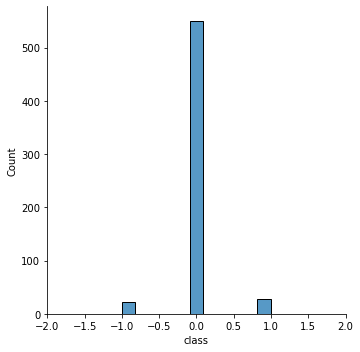

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(y_pred - y_test)
plt.xlim(-2, 2)

In [30]:
np.mean(y_pred == y_test)

0.9166666666666666

In [31]:
best_clf.score(X_test, y_test)

0.9166666666666666

(-2.0, 2.0)

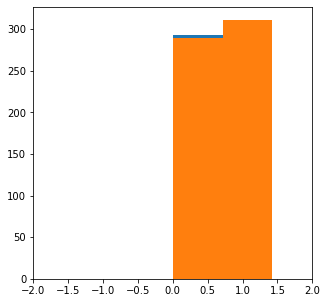

In [44]:
plt.figure(figsize=(5, 5))
plt.hist(y_test, bins=np.linspace(-5, 5, 15))
plt.hist(y_pred, bins=np.linspace(-5, 5, 15))
plt.xlim(-2, 2)

In [50]:
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
def roc_a(y_test, y_predicted_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
    roc_auc= auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [55]:
y_pred_prob = best_clf.predict_proba(X_test)

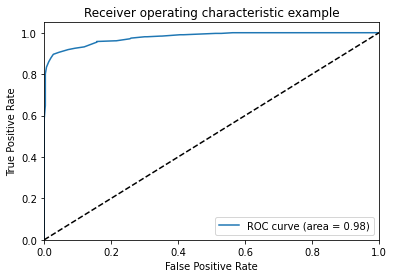

In [56]:
roc_a(y_test, y_pred_prob)

Как видим, получаем очень хороший результат. Поисследуем его.

<AxesSubplot:>

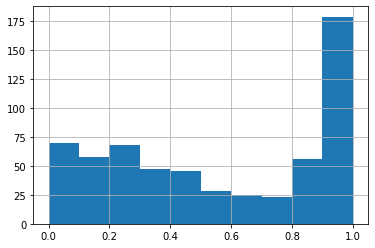

In [57]:
pd.Series(y_pred_prob[:, 1]).hist()

In [58]:
y_pr = np.where(y_pred_prob[:, 1] > 0.8, 1, 0)

In [59]:
print(classification_report(y_test, y_pr, target_names=['Non-churned', 'Churned']))

              precision    recall  f1-score   support

 Non-churned       0.80      1.00      0.89       293
     Churned       1.00      0.76      0.86       307

    accuracy                           0.88       600
   macro avg       0.90      0.88      0.88       600
weighted avg       0.90      0.88      0.88       600



Дела стали похуже.

In [60]:
y_pr = np.where(y_pred_prob[:, 0] < 0.4, 1, 0)

In [61]:
print(classification_report(y_test, y_pr, target_names=['Non-churned', 'Churned']))

              precision    recall  f1-score   support

 Non-churned       0.90      0.97      0.93       293
     Churned       0.97      0.90      0.93       307

    accuracy                           0.93       600
   macro avg       0.94      0.93      0.93       600
weighted avg       0.94      0.93      0.93       600



А так увеличился recall.

Посмотрим, как работает на новых данных, принадлежащих одному классу.

In [87]:
db = pd.read_csv('~/FINAL_DATE_',  skiprows=range(1, 30000), nrows = 2000)
db = db.drop(['Unnamed: 0'], axis=1)
X_other = db.drop(['class', 'UNIPROT_SYMBOL_A', 'UNIPROT_SYMBOL_B'], axis=1)
y_other = db['class']

In [88]:
best_clf.score(X_other, y_other)

0.184

In [89]:
print(classification_report(y_other, clf.predict(X_other), target_names=['Non-churned', 'Churned']))

              precision    recall  f1-score   support

 Non-churned       0.00      0.00      0.00         0
     Churned       1.00      0.37      0.54      2000

    accuracy                           0.37      2000
   macro avg       0.50      0.18      0.27      2000
weighted avg       1.00      0.37      0.54      2000



/home/yanina/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Отвратительно!

Теперь используем логистическую регрессию.

In [37]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=100000).fit(X_train, y_train)

In [38]:
clf.score(X_test, y_test)

0.8683333333333333

In [46]:
print(classification_report(y_test, clf.predict(X_test), target_names=['Non-churned', 'Churned']))

              precision    recall  f1-score   support

 Non-churned       0.89      0.83      0.86       293
     Churned       0.85      0.91      0.88       307

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600



Видим, что в целом полученные значения хуже, но тем не менее достаточно высокие, что говорит о том, что задача хорошо решается и подтверждает актуальность результата на random forest, по крайней мере на несбалансированной выборке. Построим графики:

In [63]:
y_lin_pr = clf.predict(X_test)

(-2.0, 2.0)

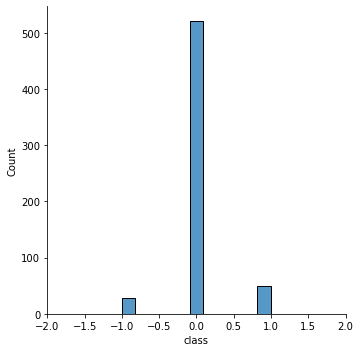

In [64]:
sns.displot(y_lin_pr - y_test)
plt.xlim(-2, 2)

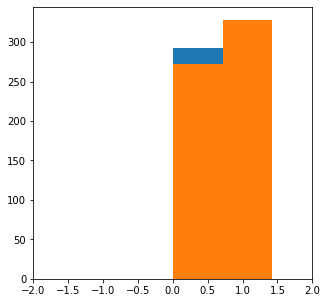

In [65]:
plt.figure(figsize=(5, 5))
plt.hist(y_test, bins=np.linspace(-5, 5, 15))
plt.hist(y_lin_pr, bins=np.linspace(-5, 5, 15))
plt.xlim(-2, 2)

In [66]:
y_pred_prob = clf.predict_proba(X_test)

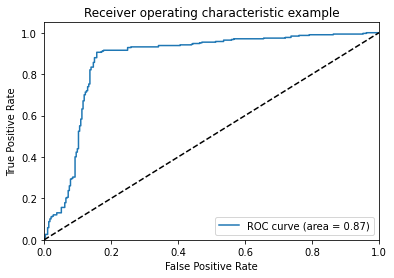

In [67]:
roc_a(y_test, y_pred_prob)

<AxesSubplot:>

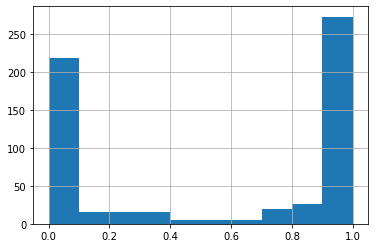

In [68]:
pd.Series(y_pred_prob[:, 1]).hist()

In [69]:
y_pr = np.where(y_pred_prob[:, 1] > 0.8, 1, 0)

In [70]:
print(classification_report(y_test, y_pr, target_names=['Non-churned', 'Churned']))

              precision    recall  f1-score   support

 Non-churned       0.83      0.85      0.84       293
     Churned       0.86      0.83      0.84       307

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600



In [71]:
y_pr = np.where(y_pred_prob[:, 0] < 0.4, 1, 0)

In [75]:
print(classification_report(y_test, y_pr, target_names=['Non-churned', 'Churned']))

              precision    recall  f1-score   support

 Non-churned       0.89      0.84      0.87       293
     Churned       0.86      0.90      0.88       307

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600



Теперь посмотрим, какие фичи оказали наибольшее влияние на результат(random forest).

In [76]:
feat_import = best_clf.feature_importances_

In [77]:
feat_df = pd.DataFrame({'features' : list(X_train), 'feat_import' : feat_import})

In [78]:
feat_df

,features,feat_import
0,seq_a_0,0.002672
1,seq_a_1,0.002145
2,seq_a_2,0.001944
3,seq_a_3,0.002504
4,seq_a_4,0.001368
...,...,...
681,seq_b_338,0.000245
682,seq_b_339,0.000646
683,seq_b_340,0.000104
684,seq_b_341,0.000432


Посмотрим, как это выглядит на графике:

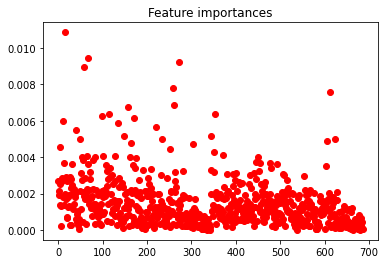

In [80]:
import matplotlib.pyplot as plt

plt.title('Feature importances')
plt.plot(range(0,686), feat_import, 'ro')
plt.show()

Попробуем выкинуть фичи, для которых значение feat_import < 0.001.

In [81]:
X_new = database.drop(['class','UNIPROT_SYMBOL_A', 'UNIPROT_SYMBOL_B'], axis=1)

In [82]:
X_new = X_new.drop(feat_df.features[feat_df.feat_import < 0.001], axis=1)
X_new.shape

(3000, 385)

In [84]:
y_new = y

In [85]:
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, test_size = 0.25, random_state = 4)

In [86]:
new_gr = rf(X_new_train, y_new_train)

Смотрим на параметры, они изменились:

In [92]:
new_gr.best_params_

{'max_depth': 12, 'n_estimators': 42}

In [93]:
new_best_clf = new_gr.best_estimator_

In [94]:
new_best_clf.score(X_new_test, y_new_test)

0.9213333333333333

In [95]:
print(classification_report(y_new_test, new_best_clf.predict(X_new_test), target_names=['Non-churned', 'Churned']))

              precision    recall  f1-score   support

 Non-churned       0.91      0.93      0.92       369
     Churned       0.93      0.91      0.92       381

    accuracy                           0.92       750
   macro avg       0.92      0.92      0.92       750
weighted avg       0.92      0.92      0.92       750



Результат стал чуточку лучше! Что ж, построим графики:

(-2.0, 2.0)

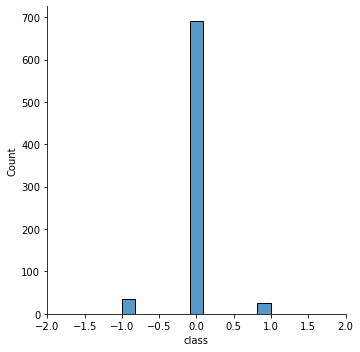

In [97]:
y_pr = new_best_clf.predict(X_new_test)
sns.displot(y_pr - y_new_test)
plt.xlim(-2, 2)

(-2.0, 2.0)

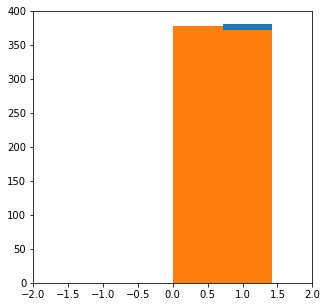

In [98]:
plt.figure(figsize=(5, 5))
plt.hist(y_new_test, bins=np.linspace(-5, 5, 15))
plt.hist(y_pr, bins=np.linspace(-5, 5, 15))
plt.xlim(-2, 2)

In [100]:
y_pred_prob = new_best_clf.predict_proba(X_new_test)

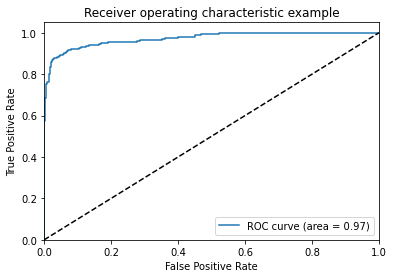

In [101]:
roc_a(y_new_test, y_pred_prob)

Что ж, это не дало сильно ощутимого улучшения.

In [102]:
y_predicted_prob = new_best_clf.predict_proba(X_new_test)

<AxesSubplot:>

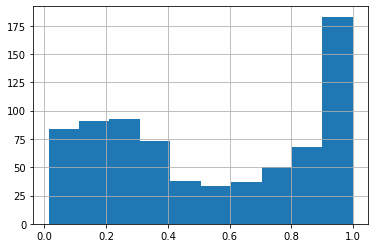

In [103]:
pd.Series(y_predicted_prob[:, 1]).hist()

In [104]:
y_pred = np.where(y_predicted_prob[:, 1] > 0.8, 1, 0)

In [105]:
print(classification_report(y_new_test, y_pred, target_names=['Non-churned', 'Churned']))

              precision    recall  f1-score   support

 Non-churned       0.74      1.00      0.85       369
     Churned       1.00      0.66      0.79       381

    accuracy                           0.83       750
   macro avg       0.87      0.83      0.82       750
weighted avg       0.87      0.83      0.82       750



In [106]:
y_p = np.where(y_predicted_prob[:, 0] < 0.4, 1, 0)

In [107]:
print(classification_report(y_new_test, y_p, target_names=['Non-churned', 'Churned']))

              precision    recall  f1-score   support

 Non-churned       0.88      0.98      0.92       369
     Churned       0.97      0.87      0.92       381

    accuracy                           0.92       750
   macro avg       0.92      0.92      0.92       750
weighted avg       0.93      0.92      0.92       750



Кажется, лучше оставить все без изменений.

Обучим random forest на несбалансированной выборке(но там хотя бы есть элементы обоих классов)))0).

In [109]:
db = pd.read_csv('~/FINAL_DATE_', nrows=10000)
db = db.drop(['Unnamed: 0'], axis=1)
X = db.drop(['class', 'UNIPROT_SYMBOL_A', 'UNIPROT_SYMBOL_B'], axis=1)
y = db['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 5)
gr = rf(X_train, y_train)

In [110]:
print(gr.best_params_)
best_clf = gr.best_estimator_
print(best_clf.score(X_test, y_test))
print(classification_report(y_test, best_clf.predict(X_test), target_names=['Non-churned', 'Churned']))

{'max_depth': 24, 'n_estimators': 24}
0.9264
              precision    recall  f1-score   support

 Non-churned       0.94      0.54      0.68       368
     Churned       0.93      0.99      0.96      2132

    accuracy                           0.93      2500
   macro avg       0.93      0.76      0.82      2500
weighted avg       0.93      0.93      0.92      2500



Видим, что recall проседает.

(-2.0, 2.0)

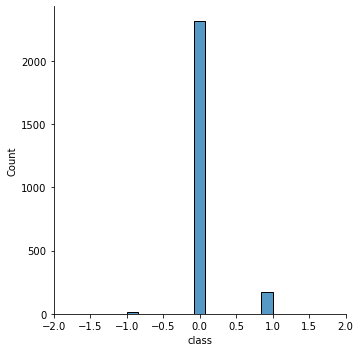

In [111]:
y_pr = best_clf.predict(X_test)
sns.displot(y_pr - y_test)
plt.xlim(-2, 2)

(-2.0, 2.0)

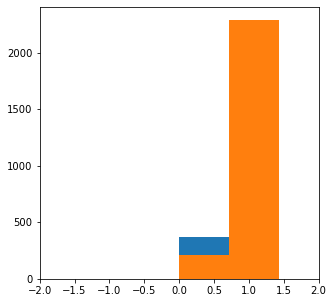

In [112]:
plt.figure(figsize=(5, 5))
plt.hist(y_test, bins=np.linspace(-5, 5, 15))
plt.hist(y_pr, bins=np.linspace(-5, 5, 15))
plt.xlim(-2, 2)

In [115]:
y_predicted_prob = best_clf.predict_proba(X_test)

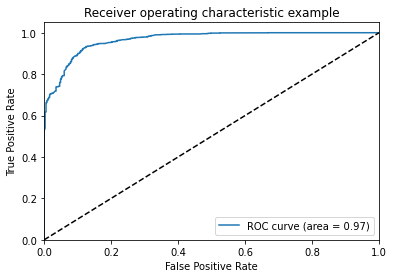

In [116]:
roc_a(y_test, y_predicted_prob)

<AxesSubplot:>

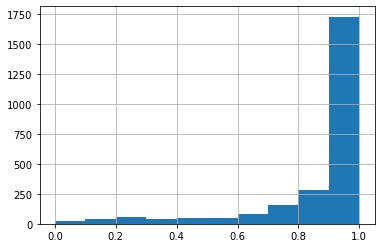

In [117]:
pd.Series(y_predicted_prob[:, 1]).hist()

In [118]:
y_p = np.where(y_predicted_prob[:, 1] > 0.8, 1, 0)
print(classification_report(y_test, y_p, target_names=['Non-churned', 'Churned']))

              precision    recall  f1-score   support

 Non-churned       0.66      0.88      0.76       368
     Churned       0.98      0.92      0.95      2132

    accuracy                           0.92      2500
   macro avg       0.82      0.90      0.85      2500
weighted avg       0.93      0.92      0.92      2500



Просел precision.

In [120]:
y_p = np.where(y_predicted_prob[:, 0] < 0.4, 1, 0)
print(classification_report(y_test, y_p, target_names=['Non-churned', 'Churned']))

              precision    recall  f1-score   support

 Non-churned       0.93      0.64      0.75       368
     Churned       0.94      0.99      0.97      2132

    accuracy                           0.94      2500
   macro avg       0.93      0.81      0.86      2500
weighted avg       0.94      0.94      0.93      2500



Посмотрим, что будет, если убрать какое-то количество фич.

In [122]:
feat_import = best_clf.feature_importances_
X_new = X.drop(feat_df.features[feat_df.feat_import < 0.001], axis=1)
feat_df = pd.DataFrame({'features' : list(X_train), 'feat_import' : feat_import})

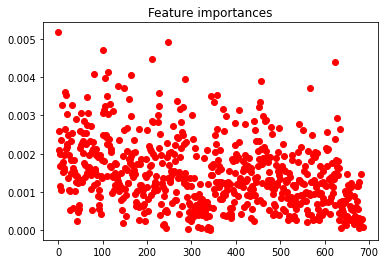

In [123]:
plt.title('Feature importances')
plt.plot(range(0,686), feat_import, 'ro')
plt.show()

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, random_state = 5)
gr = rf(X_train, y_train)

(-2.0, 2.0)

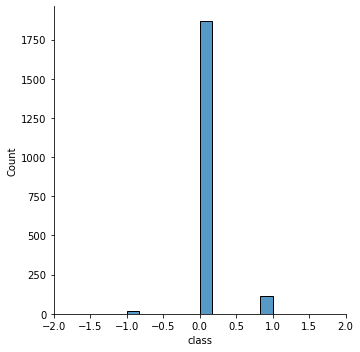

In [128]:
y_pr = best_clf.predict(X_test)
sns.displot(y_pr - y_test)
plt.xlim(-2, 2)

(-2.0, 2.0)

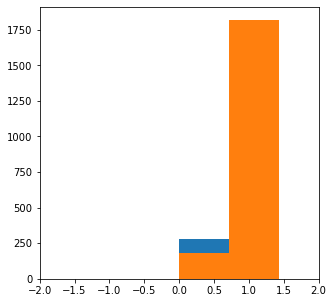

In [129]:
plt.figure(figsize=(5, 5))
plt.hist(y_test, bins=np.linspace(-5, 5, 15))
plt.hist(y_pr, bins=np.linspace(-5, 5, 15))
plt.xlim(-2, 2)

In [130]:
y_predicted_prob = best_clf.predict_proba(X_test)

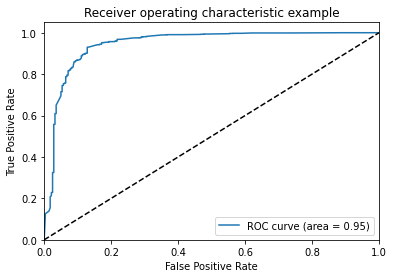

In [131]:
roc_a(y_test, y_predicted_prob)

<AxesSubplot:>

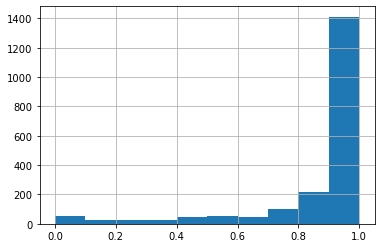

In [132]:
pd.Series(y_predicted_prob[:, 1]).hist()

In [133]:
y_p = np.where(y_predicted_prob[:, 1] > 0.8, 1, 0)
print(classification_report(y_test, y_p, target_names=['Non-churned', 'Churned']))

              precision    recall  f1-score   support

 Non-churned       0.66      0.87      0.75       280
     Churned       0.98      0.93      0.95      1720

    accuracy                           0.92      2000
   macro avg       0.82      0.90      0.85      2000
weighted avg       0.93      0.92      0.92      2000



In [134]:
y_p = np.where(y_predicted_prob[:, 0] < 0.4, 1, 0)
print(classification_report(y_test, y_p, target_names=['Non-churned', 'Churned']))

              precision    recall  f1-score   support

 Non-churned       0.86      0.69      0.77       280
     Churned       0.95      0.98      0.97      1720

    accuracy                           0.94      2000
   macro avg       0.90      0.84      0.87      2000
weighted avg       0.94      0.94      0.94      2000

